<a href="https://colab.research.google.com/github/skyshine460/GHG_Direct_Emissions/blob/main/submit_ghg48_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 初期設定

In [ ]:
# pip install pygeohash

In [ ]:
# pip install catboost

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
from tqdm import tqdm
import joblib
import math

import pygeohash as pgh

from concurrent.futures import ThreadPoolExecutor

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import KFold
from sklearn.metrics import *
from sklearn.preprocessing import LabelEncoder

import gc
gc.collect()

import os

np.random.seed(42)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# データの読み込み

In [ ]:
# 予測モデルを訓練するためのデータセット
train_df = pd.read_csv('/content/drive/MyDrive/GHGの排出量の予測にチャレンジしよう！（SMBC Group GREEN×DATA Challenge 2024）/提供データ/train.csv')

# 予測モデルに推論（予測)させるデータセット
test_df = pd.read_csv('/content/drive/MyDrive/GHGの排出量の予測にチャレンジしよう！（SMBC Group GREEN×DATA Challenge 2024）/提供データ/test.csv')

In [ ]:
# 各カラムのデータ型と欠損値（nan）を表示
def information_df(df):
    pd.set_option('display.max_rows', None)
    type_series = df.dtypes
    nunique_series = df.nunique()
    nan_count_series = df.isnull().sum()
    unique_values_series = df.apply(lambda col: list(col.unique()))
    info_df = pd.DataFrame({
        'dtypes': type_series,
        'NaN Count': nan_count_series,
        'Nunique': nunique_series,
        'Unique Values': unique_values_series,
    })
    print(df.shape)
    return info_df

def normal_distribution_fit(df, col):

    # 正規分布のフィッティング
    from scipy.stats import norm
    from scipy import stats
    import matplotlib.pyplot as plt
    import seaborn as sns

    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    # カテゴリデータかどうかを判定
    if df[col].dtype == 'object' or df[col].dtype.name == 'category':
        # カテゴリデータの場合
        sns.countplot(x=df[col], ax=ax[0])
        ax[0].set_title('Bar Plot of Categorical Data')
    else:
        # 数値データの場合
        sns.histplot(df[col], kde=True, stat='density', ax=ax[0])
        # 正規分布のフィット
        sns.histplot(df[col], stat='density', ax=ax[0], bins=50)
        x = np.linspace(df[col].min(), df[col].max(), 100)
        ax[0].plot(x, norm.pdf(x, df[col].mean(), df[col].std()), color='red')
        ax[0].set_title('Histogram with Normal Distribution Fit')

        # Q-Qプロット
        stats.probplot(df[col], plot=ax[1])
        ax[1].set_title('Q-Q Plot')

    plt.tight_layout()
    plt.show()

    # 数値データの場合のみ歪度と尖度を計算
    if df[col].dtype != 'object' and df[col].dtype.name != 'category':
        print(f"Skewness: {df[col].skew()}")
        print(f"Kurtosis: {df[col].kurt()}")

    # 欠損値の確認
    print(f"isnull: {df[col].isnull().sum()}")

In [ ]:
information_df(train_df)

(4655, 22)


,dtypes,NaN Count,Nunique,Unique Values
Unnamed: 0,int64,0,4655,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
FacilityName,object,0,4531,"[VISCOFAN USA INC, CORNWELL STATION - DOMINION..."
Latitude,float64,102,4492,"[40.141389, 38.475305, 39.29982, 35.490363, 41..."
Longitude,float64,102,4486,"[-87.581111, -81.278957, -80.85717, -119.04295..."
LocationAddress,object,179,4435,"[915 N MICHIGAN AVE, 200 RIVER HAVEN ROAD, 304..."
City,object,0,2588,"[DANVILLE, CLENDENIN, GREENWOOD, BAKERSFIELD, ..."
State,object,0,54,"[IL, WV, CA, OH, OK, NM, TN, LA, TX, IN, NC, M..."
ZIP,object,0,3758,"[61832, 25045-9304, 26415, 93308, 441031047, 7..."
County,object,70,1165,"[VERMILION, KANAWHA, RITCHIE, KERN, CUYAHOGA, ..."
FIPScode,float64,73,1646,"[17183.0, 54039.0, 54085.0, 6029.0, 39035.0, 4..."


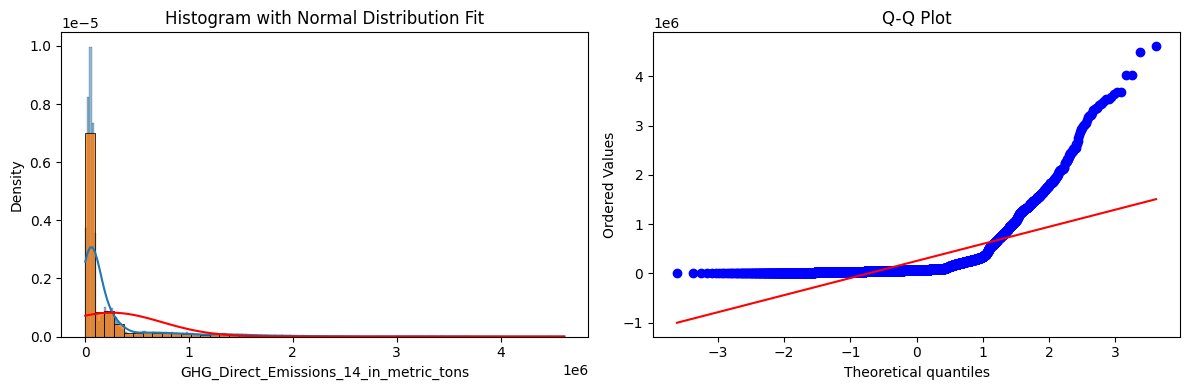

Skewness: 3.6649052199295338
Kurtosis: 16.560320863687245
isnull: 0


In [ ]:
normal_distribution_fit(train_df, 'GHG_Direct_Emissions_14_in_metric_tons')

評価指標はRMSLEであり、ヒストグラムも右に裾が長いグラフなので、対数変換を行う。

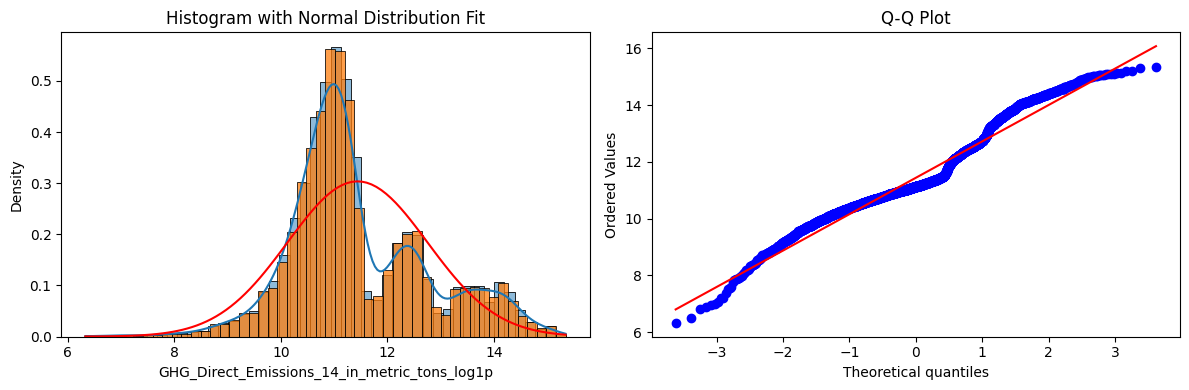

Skewness: 0.545884275422693
Kurtosis: 0.3515490436747801
isnull: 0


In [ ]:
train_df['GHG_Direct_Emissions_14_in_metric_tons_log1p'] = np.log1p(train_df['GHG_Direct_Emissions_14_in_metric_tons'])
normal_distribution_fit(train_df, 'GHG_Direct_Emissions_14_in_metric_tons_log1p')

Peaks positions: [11.19761227 12.2794425  13.72188282]
thresholds: [11.738527387432828, 13.000662661644935]


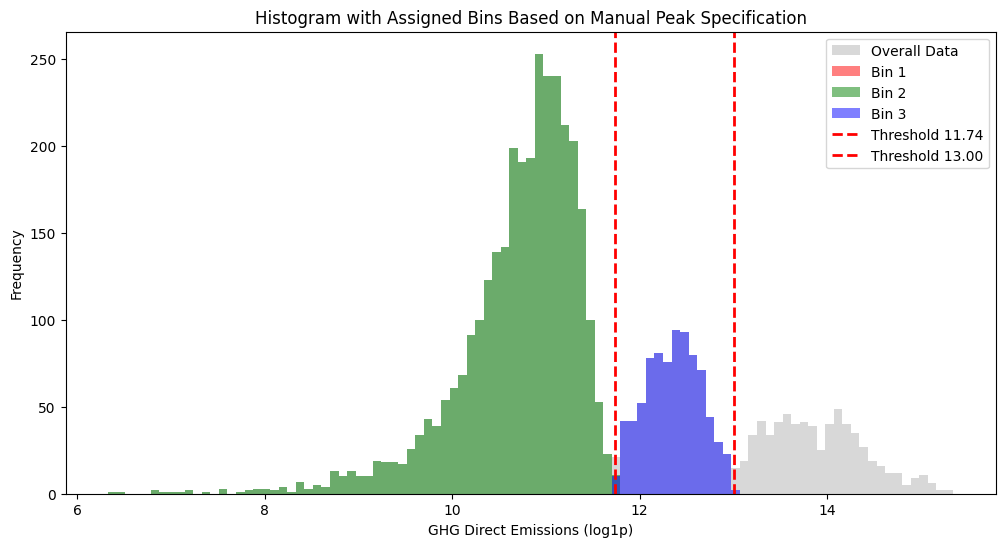

In [ ]:
from scipy.signal import find_peaks

# ヒストグラムを作成し、ピークの検出
hist, bin_edges = np.histogram(train_df['GHG_Direct_Emissions_14_in_metric_tons_log1p'], bins=25)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
peaks, _ = find_peaks(hist, distance=3)  # ピークの検出

print(f"Peaks positions: {bin_centers[peaks]}")
# # ピークの位置を手動で指定
peaks = peaks.tolist()

# ピークの位置に基づいて閾値を設定
if len(peaks) == 3:
    thresholds = [(bin_centers[peaks[i]] + bin_centers[peaks[i + 1]]) / 2 for i in range(len(peaks) - 1)]
    print(f"thresholds: {thresholds}")

    # 各データポイントがどのビンに属するかを判断する関数
    def assign_bin(value):
        if np.isnan(value):  # np.isnan() を使って NaN のチェックを行う
            return 0
        elif value < thresholds[0]:
            return 1  # 第1ピークに属する
        elif value < thresholds[1]:
            return 2  # 第2ピークに属する
        else:
            return 3  # 第3ピークに属する

    # 各データポイントにラベルを適用
    labels = train_df['GHG_Direct_Emissions_14_in_metric_tons_log1p'].apply(assign_bin)

    # 共通のビン境界を作成
    bins = np.linspace(train_df['GHG_Direct_Emissions_14_in_metric_tons_log1p'].min(),
                       train_df['GHG_Direct_Emissions_14_in_metric_tons_log1p'].max(), 100)

    # 全体のヒストグラムをプロット
    plt.figure(figsize=(12, 6))
    plt.hist(train_df['GHG_Direct_Emissions_14_in_metric_tons_log1p'], bins=bins, alpha=0.3, color='gray', label='Overall Data', density=False)

    # 各ビンに属するデータを可視化
    colors = ['red', 'green', 'blue']
    for i in range(3):
        plt.hist(train_df['GHG_Direct_Emissions_14_in_metric_tons_log1p'][labels == i], bins=bins, alpha=0.5, color=colors[i], label=f'Bin {i+1}', density=False)

    # 閾値に縦線を描画
    for threshold in thresholds:
        plt.axvline(x=threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold {threshold:.2f}')

    plt.xlabel('GHG Direct Emissions (log1p)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.title('Histogram with Assigned Bins Based on Manual Peak Specification')
    plt.show()

In [ ]:
information_df(test_df)

(2508, 21)


,dtypes,NaN Count,Nunique,Unique Values
Unnamed: 0,int64,0,2508,"[4655, 4656, 4657, 4658, 4659, 4660, 4661, 466..."
FacilityName,object,0,2462,"[ROGER AOTSCHEGAROW, EPNG STATION 6543 LORDSBU..."
Latitude,float64,56,2437,"[38.03304, 32.31603, 41.2515, 44.95966, 32.818..."
Longitude,float64,56,2435,"[-97.97317, -108.6068, -78.74244, -93.19341, -..."
LocationAddress,object,113,2386,"[1910 SOUTH BROADACRES ROAD, nan, 3831 ROUTE 2..."
City,object,0,1647,"[HUTCHINSON, LORDSBURG, BROCKPORT, SAINT PAUL,..."
State,object,0,54,"[KS, NM, PA, MN, CA, MS, MT, AZ, IN, NY, IL, F..."
ZIP,object,0,2152,"[67501, 88045, 15823, 551141895, 92123, 38606,..."
County,object,45,865,"[RENO, HIDALGO, JEFFERSON, RAMSEY, SAN DIEGO, ..."
FIPScode,float64,45,1162,"[20155.0, 35023.0, 42065.0, 27123.0, 6073.0, 2..."


In [ ]:
# object型をカテゴリ型に変換する
def convert_object_to_category(df):
  for col in df.columns:
      if df[col].dtype == "object":  # object型の列を探す
          df[col] = df[col].astype("category")  # カテゴリ型に変換
  return df

train_df = convert_object_to_category(train_df)
test_df = convert_object_to_category(test_df)

In [ ]:
test_df.columns

Index(['Unnamed: 0', 'FacilityName', 'Latitude', 'Longitude',
       'LocationAddress', 'City', 'State', 'ZIP', 'County', 'FIPScode',
       'PrimaryNAICS', 'SecondPrimaryNAICS', 'IndustryType',
       'TRI_Air_Emissions_10_in_lbs', 'TRI_Air_Emissions_11_in_lbs',
       'TRI_Air_Emissions_12_in_lbs', 'TRI_Air_Emissions_13_in_lbs',
       'GHG_Direct_Emissions_10_in_metric_tons',
       'GHG_Direct_Emissions_11_in_metric_tons',
       'GHG_Direct_Emissions_12_in_metric_tons',
       'GHG_Direct_Emissions_13_in_metric_tons'],
      dtype='object')

In [ ]:
def trans_log1p(df):
  for i in range(10, 14):
    col_name = f'GHG_Direct_Emissions_{i}_in_metric_tons'
    col_log_name = f'{col_name}_log1p'

    df[col_log_name] = np.log1p(df[col_name])
  return df

train_df = trans_log1p(train_df)
test_df = trans_log1p(test_df)

In [ ]:
train_df.head()

,Unnamed: 0,FacilityName,Latitude,Longitude,LocationAddress,City,State,ZIP,County,FIPScode,PrimaryNAICS,SecondPrimaryNAICS,IndustryType,TRI_Air_Emissions_10_in_lbs,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,GHG_Direct_Emissions_14_in_metric_tons,GHG_Direct_Emissions_14_in_metric_tons_log1p,GHG_Direct_Emissions_10_in_metric_tons_log1p,GHG_Direct_Emissions_11_in_metric_tons_log1p,GHG_Direct_Emissions_12_in_metric_tons_log1p,GHG_Direct_Emissions_13_in_metric_tons_log1p
0,0,VISCOFAN USA INC,40.141389,-87.581111,915 N MICHIGAN AVE,DANVILLE,IL,61832,VERMILION,17183.0,326121,NaN,Other,31566.709644,26644.986107,23410.379903,31809.857564,64816.958901,36588.744606,37907.936721,45598.125851,52973.139946,10.877559,11.079338,10.507523,10.542942,10.727644
1,1,"CORNWELL STATION - DOMINION TRANSMISSION, INC",38.475305,-81.278957,200 RIVER HAVEN ROAD,CLENDENIN,WV,25045-9304,KANAWHA,54039.0,486210,NaN,Petroleum and Natural Gas Systems,NaN,NaN,NaN,NaN,55507.543666,72387.334115,58225.196089,76376.547318,55910.066617,10.931518,10.924292,11.189800,10.972091,11.243444
2,2,WEST UNION COMPRESSOR STATION,39.299820,-80.857170,3041 LONG RUN RD.,GREENWOOD,WV,26415,RITCHIE,54085.0,211112,NaN,Petroleum and Natural Gas Systems,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55679.543214,10.927386,NaN,NaN,NaN,NaN
3,3,"DOUBLE ""C"" LIMITED",35.490363,-119.042957,10245 OILFIELD ROAD,BAKERSFIELD,CA,93308,KERN,6029.0,221112,NaN,Power Plants,NaN,NaN,NaN,NaN,54811.222708,69339.923002,63647.340038,53799.011225,61411.902782,11.025375,10.911668,11.146791,11.061129,10.893029
4,4,LAKESHORE PLANT,41.532802,-81.636448,6800 S MARGINAL RD,CLEVELAND,OH,441031047,CUYAHOGA,39035.0,221112,NaN,Power Plants,29553.796627,28337.832145,30840.825454,25153.901905,81812.306362,53823.561587,77391.157768,17662.966241,43100.469774,10.671312,11.312195,10.893485,11.256641,9.779282


In [ ]:
def plot_histograms_with_thresholds(train_df, test_df, column_num, thresholds, bins=100, x_max=16, x_min=0):
    # カラム名を作成
    col_log_name = f'GHG_Direct_Emissions_{column_num}_in_metric_tons_log1p'

    # 共通のビン境界を作成
    bins = np.linspace(min(train_df[col_log_name].min(), test_df[col_log_name].min()),
                       max(train_df[col_log_name].max(), test_df[col_log_name].max()), bins)

    # ヒストグラムのプロット
    plt.figure(figsize=(12, 6))
    plt.hist(train_df[col_log_name], bins=bins, alpha=0.5, color='blue', label='Train Data', density=False, edgecolor='black')
    plt.hist(test_df[col_log_name], bins=bins, alpha=0.5, color='orange', label='Test Data', density=False, edgecolor='black')

    # 閾値に縦線を描画
    for threshold in thresholds:
        plt.axvline(x=threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold {threshold:.2f}')

    # x軸の範囲設定
    plt.xlim(left=x_min, right=x_max)
    plt.xlabel(f'GHG Direct Emissions {column_num} (log1p)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.title(f'Histogram of Train and Test Data for GHG Direct Emissions {column_num}')
    plt.show()

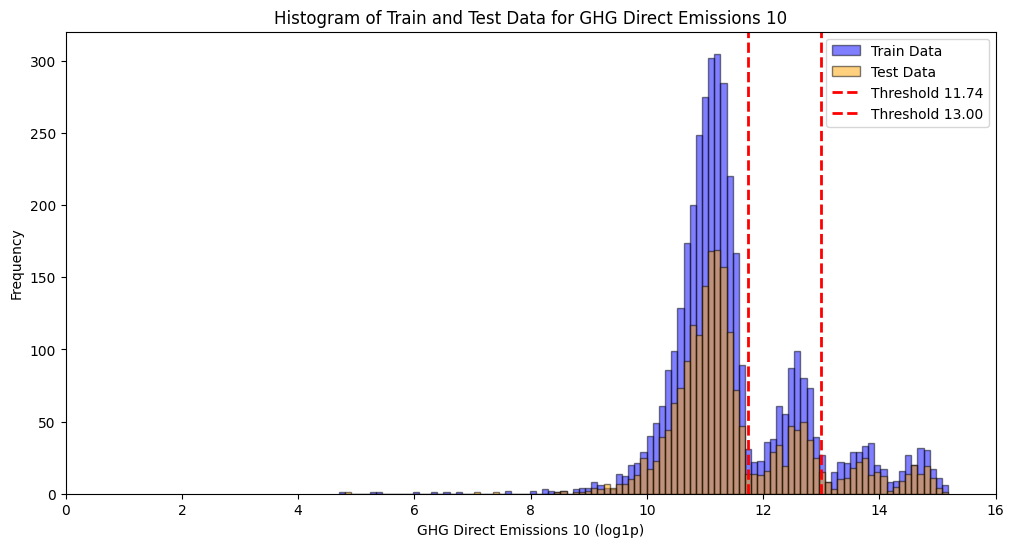

In [ ]:
plot_histograms_with_thresholds(train_df, test_df, column_num=10, thresholds=thresholds)

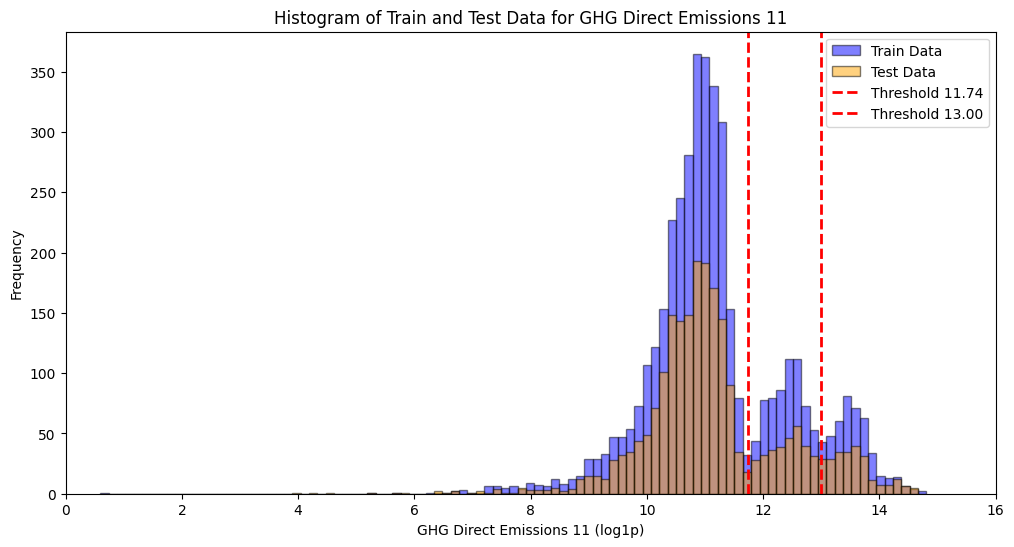

In [ ]:
plot_histograms_with_thresholds(train_df, test_df, column_num=11, thresholds=thresholds)

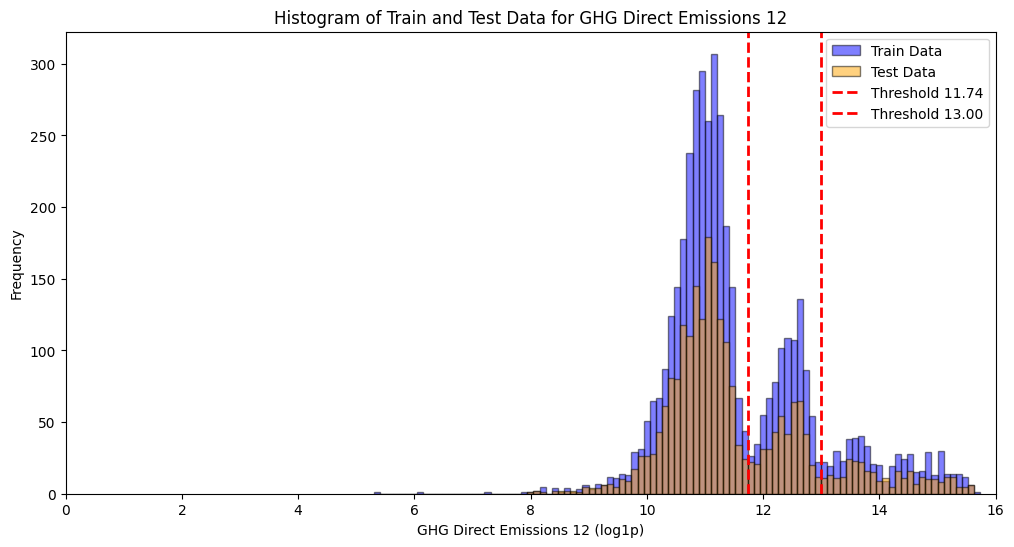

In [ ]:
plot_histograms_with_thresholds(train_df, test_df, column_num=12, thresholds=thresholds)

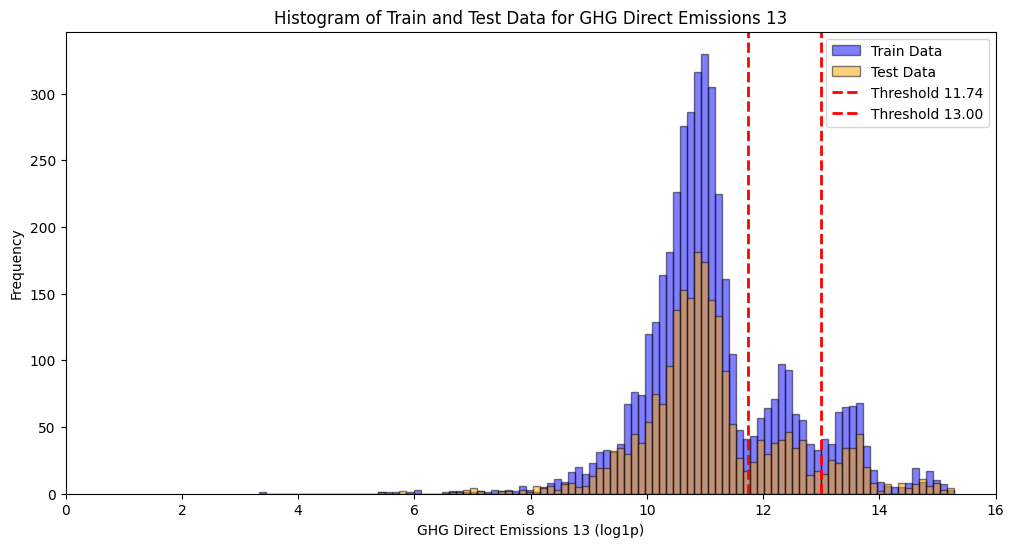

In [ ]:
plot_histograms_with_thresholds(train_df, test_df, column_num=13, thresholds=thresholds)

In [ ]:
train_df.head()

,Unnamed: 0,FacilityName,Latitude,Longitude,LocationAddress,City,State,ZIP,County,FIPScode,PrimaryNAICS,SecondPrimaryNAICS,IndustryType,TRI_Air_Emissions_10_in_lbs,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,GHG_Direct_Emissions_14_in_metric_tons,GHG_Direct_Emissions_14_in_metric_tons_log1p,GHG_Direct_Emissions_10_in_metric_tons_log1p,GHG_Direct_Emissions_11_in_metric_tons_log1p,GHG_Direct_Emissions_12_in_metric_tons_log1p,GHG_Direct_Emissions_13_in_metric_tons_log1p
0,0,VISCOFAN USA INC,40.141389,-87.581111,915 N MICHIGAN AVE,DANVILLE,IL,61832,VERMILION,17183.0,326121,NaN,Other,31566.709644,26644.986107,23410.379903,31809.857564,64816.958901,36588.744606,37907.936721,45598.125851,52973.139946,10.877559,11.079338,10.507523,10.542942,10.727644
1,1,"CORNWELL STATION - DOMINION TRANSMISSION, INC",38.475305,-81.278957,200 RIVER HAVEN ROAD,CLENDENIN,WV,25045-9304,KANAWHA,54039.0,486210,NaN,Petroleum and Natural Gas Systems,NaN,NaN,NaN,NaN,55507.543666,72387.334115,58225.196089,76376.547318,55910.066617,10.931518,10.924292,11.189800,10.972091,11.243444
2,2,WEST UNION COMPRESSOR STATION,39.299820,-80.857170,3041 LONG RUN RD.,GREENWOOD,WV,26415,RITCHIE,54085.0,211112,NaN,Petroleum and Natural Gas Systems,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55679.543214,10.927386,NaN,NaN,NaN,NaN
3,3,"DOUBLE ""C"" LIMITED",35.490363,-119.042957,10245 OILFIELD ROAD,BAKERSFIELD,CA,93308,KERN,6029.0,221112,NaN,Power Plants,NaN,NaN,NaN,NaN,54811.222708,69339.923002,63647.340038,53799.011225,61411.902782,11.025375,10.911668,11.146791,11.061129,10.893029
4,4,LAKESHORE PLANT,41.532802,-81.636448,6800 S MARGINAL RD,CLEVELAND,OH,441031047,CUYAHOGA,39035.0,221112,NaN,Power Plants,29553.796627,28337.832145,30840.825454,25153.901905,81812.306362,53823.561587,77391.157768,17662.966241,43100.469774,10.671312,11.312195,10.893485,11.256641,9.779282


In [ ]:
def assign_bin(value):
    if np.isnan(value):  # np.isnan() を使って NaN のチェックを行う
        return 0
    elif value < thresholds[0]:
        return 1  # 第1ピークに属する
    elif value < thresholds[1]:
        return 2  # 第2ピークに属する
    else:
        return 3  # 第3ピークに属する

thresholds=[11.738527387432828, 13.000662661644935]

def ghg_binning(df):
    df['GHG_10_bins'] = df['GHG_Direct_Emissions_10_in_metric_tons_log1p'].apply(assign_bin)
    df['GHG_11_bins'] = df['GHG_Direct_Emissions_11_in_metric_tons_log1p'].apply(assign_bin)
    df['GHG_12_bins'] = df['GHG_Direct_Emissions_12_in_metric_tons_log1p'].apply(assign_bin)
    df['GHG_13_bins'] = df['GHG_Direct_Emissions_13_in_metric_tons_log1p'].apply(assign_bin)
    return df

train_df = ghg_binning(train_df)
test_df = ghg_binning(test_df)

In [ ]:
naics_types      = {11: 'Agriculture, Forestry, Fishing and Hunting',
                    21: 'Mining, Quarrying, and Oil and Gas Extraction',
                    22: 'Utilities',
                    23: 'Construction',
                    31: 'Manufacturing',
                    32: 'Manufacturing',
                    33: 'Manufacturing',
                    42: 'Wholesale Trade',
                    44: 'Retail Trade',
                    45: 'Retail Trade',
                    48: 'Transportation and Warehousing',
                    49: 'Transportation and Warehousing',
                    51: 'Information',
                    52: 'Finance and Insurance',
                    53: 'Real Estate and Rental and Leasing',
                    54: 'Professional, Scientific, and Technical Services',
                    55: 'Management of Companies and Enterprises',
                    56: 'Administrative and Support and Waste Management and Remediation Services',
                    61: 'Educational Services',
                    62: 'Health Care and Social Assistance',
                    71: 'Arts, Entertainment, and Recreation',
                    72: 'Accommodation and Food Services',
                    81: 'Other Services (except Public Administration)',
                    92: 'Public Administration'}

def trans_naics(df):
    df['PrimaryNAICS_1-2'] = df['PrimaryNAICS'].astype(str).str[:2].astype(float)
    df['PrimaryNAICS_1-3'] = df['PrimaryNAICS'].astype(str).str[:3].astype(float)
    df['PrimaryNAICS_1-4'] = df['PrimaryNAICS'].astype(str).str[:4].astype(float)
    df['PrimaryNAICS_1-5'] = df['PrimaryNAICS'].astype(str).str[:5].astype(float)
    df['NAICS_Type'] = df['PrimaryNAICS_1-2'].map(naics_types).astype('category')

    # 'na' などの変換できない値を NaN にしてから整数に変換
    df['SecondPrimaryNAICS_1-2'] = pd.to_numeric(df['SecondPrimaryNAICS'].astype(str).str[:2], errors='coerce')
    df['Sub_NAICS_Type'] = df['PrimaryNAICS_1-2'].map(naics_types).astype('category')

    return df

train_df = trans_naics(train_df)
test_df = trans_naics(test_df)

In [ ]:
# pd.set_option('display.max_columns', None)
# # 欠損値を確認したいカラムのリストを指定
# columns = [
#     'GHG_Direct_Emissions_10_in_metric_tons',
#     'GHG_Direct_Emissions_11_in_metric_tons',
#     'GHG_Direct_Emissions_12_in_metric_tons',
#     'GHG_Direct_Emissions_13_in_metric_tons'
# ]

# # 欠損値を持つ行を抽出
# missing_values_df = train_df[train_df[columns].isna().any(axis=1)]

# # 結果を表示
# missing_values_df

In [ ]:
# # K-meanで欠損値を埋めるため、事前の欠損値を処理。最後に戻す
# fill_mean_columns = [
#        'TRI_Air_Emissions_10_in_lbs', 'TRI_Air_Emissions_11_in_lbs',
#        'TRI_Air_Emissions_12_in_lbs', 'TRI_Air_Emissions_13_in_lbs']

# for col in fill_mean_columns:
#     train_df[col].fillna(train_df[col].mean(), inplace=True)
#     test_df[col].fillna(test_df[col].mean(), inplace=True)

In [ ]:
# 平均を計算するカラムを指定
columns = [
    'GHG_Direct_Emissions_10_in_metric_tons',
    'GHG_Direct_Emissions_11_in_metric_tons',
    'GHG_Direct_Emissions_12_in_metric_tons',
    'GHG_Direct_Emissions_13_in_metric_tons'
]

# 各行の平均値を計算し、新しいカラムとして追加
train_df['GHG_Direct_Emissions_Mean'] = train_df[columns].mean(axis=1)
test_df['GHG_Direct_Emissions_Mean'] = test_df[columns].mean(axis=1)

In [ ]:
# features = [
#         'PrimaryNAICS', 'PrimaryNAICS_1-2',
#        'TRI_Air_Emissions_10_in_lbs', 'TRI_Air_Emissions_11_in_lbs',
#        'TRI_Air_Emissions_12_in_lbs', 'TRI_Air_Emissions_13_in_lbs',
#         'GHG_10_bins', 'GHG_11_bins', 'GHG_12_bins', 'GHG_13_bins',
#         'GHG_Direct_Emissions_Mean'
# ]
# train_df[features].isnull().sum()

In [ ]:
# from sklearn.cluster import KMeans

# # K-meansクラスタリングを使って欠損値を埋める関数を定義
# def ghg_fillna_with_kmeans(df, features, fill_columns, n_clusters=3):
#     kmeans_features = df[features]

#     # 欠損値が含まれているとKMeansがエラーになるため、事前に欠損値を補完
#     kmeans_features = kmeans_features.fillna(kmeans_features.mean())

#     # K-meansクラスタリングを実行してクラスタラベルを付与
#     kmeans = KMeans(n_clusters=n_clusters, random_state=42)
#     df['Cluster'] = kmeans.fit_predict(kmeans_features)

#     # 指定したカラムに対して欠損値を埋める
#     for col in fill_columns:
#         # クラスタごとの平均を計算して各行に適用する
#         mean_values = df.groupby('Cluster')[col].transform('mean')
#         df[col] = df[col].fillna(mean_values)

#         # log1p変換後のカラムが存在する場合、欠損値を埋める
#         log_col = col + '_log1p'
#         if log_col in df.columns:
#             df[log_col] = df[log_col].fillna(np.log1p(mean_values))

#     return df.drop(columns=['Cluster'])

# features = [
#         'PrimaryNAICS_1-2', 'PrimaryNAICS_1-5',
#       #  'TRI_Air_Emissions_10_in_lbs', 'TRI_Air_Emissions_11_in_lbs',
#       #  'TRI_Air_Emissions_12_in_lbs', 'TRI_Air_Emissions_13_in_lbs',
#         # 'GHG_10_bins', 'GHG_11_bins', 'GHG_12_bins', 'GHG_13_bins',
#         'GHG_Direct_Emissions_Mean'
# ]

# fill_columns = [
#         'GHG_Direct_Emissions_10_in_metric_tons',
#        'GHG_Direct_Emissions_11_in_metric_tons',
#        'GHG_Direct_Emissions_12_in_metric_tons',
#        'GHG_Direct_Emissions_13_in_metric_tons',]

# train_df = ghg_fillna_with_kmeans(train_df, features, fill_columns)
# test_df = ghg_fillna_with_kmeans(test_df, features, fill_columns)
# train_df.head()


In [ ]:
# train_df = ghg_binning(train_df)
# test_df = ghg_binning(test_df)

In [ ]:
# plot_histograms_with_thresholds(train_df, test_df, column_num=13, thresholds=thresholds)

In [ ]:
information_df(test_df)

(2508, 36)


,dtypes,NaN Count,Nunique,Unique Values
Unnamed: 0,int64,0,2508,"[4655, 4656, 4657, 4658, 4659, 4660, 4661, 466..."
FacilityName,category,0,2462,"[ROGER AOTSCHEGAROW, EPNG STATION 6543 LORDSBU..."
Latitude,float64,56,2437,"[38.03304, 32.31603, 41.2515, 44.95966, 32.818..."
Longitude,float64,56,2435,"[-97.97317, -108.6068, -78.74244, -93.19341, -..."
LocationAddress,category,113,2386,"[1910 SOUTH BROADACRES ROAD, nan, 3831 ROUTE 2..."
City,category,0,1647,"[HUTCHINSON, LORDSBURG, BROCKPORT, SAINT PAUL,..."
State,category,0,54,"[KS, NM, PA, MN, CA, MS, MT, AZ, IN, NY, IL, F..."
ZIP,category,0,2152,"[67501, 88045, 15823, 551141895, 92123, 38606,..."
County,category,45,865,"[RENO, HIDALGO, JEFFERSON, RAMSEY, SAN DIEGO, ..."
FIPScode,float64,45,1162,"[20155.0, 35023.0, 42065.0, 27123.0, 6073.0, 2..."


# Locationにかかわる特徴量

GHGが高い場所はまばら。地域差や業種に集約できる可能性はあり。
欠損値はそのままとして進める。

# industryにかかわる特徴量

'PrimaryNAICS'について

数字に応じたグループあり。
特に最初の2文字が業種を表す。

数値の大きさに大きな意味はなさそうなので、categoryか新しい特徴量として使用するのが良いかもしれない。

In [ ]:
def create_features1(df):

    df['TRI_diff_11-10'] = df['TRI_Air_Emissions_11_in_lbs'] - df['TRI_Air_Emissions_10_in_lbs']
    df['TRI_diff_12-11'] = df['TRI_Air_Emissions_12_in_lbs'] - df['TRI_Air_Emissions_11_in_lbs']
    df['TRI_diff_13-12'] = df['TRI_Air_Emissions_13_in_lbs'] - df['TRI_Air_Emissions_12_in_lbs']

    df['TRI_Growth_Rate_11'] = np.where(
        df['TRI_Air_Emissions_10_in_lbs'].notna() & (df['TRI_Air_Emissions_10_in_lbs'] != 0),
        (df['TRI_Air_Emissions_11_in_lbs'] - df['TRI_Air_Emissions_10_in_lbs']) / df['TRI_Air_Emissions_10_in_lbs'],
        np.nan
    )

    df['TRI_Growth_Rate_12'] = np.where(
        df['TRI_Air_Emissions_11_in_lbs'].notna() & (df['TRI_Air_Emissions_11_in_lbs'] != 0),
        (df['TRI_Air_Emissions_12_in_lbs'] - df['TRI_Air_Emissions_11_in_lbs']) / df['TRI_Air_Emissions_11_in_lbs'],
        np.nan
    )

    df['TRI_Growth_Rate_13'] = np.where(
        df['TRI_Air_Emissions_12_in_lbs'].notna() & (df['TRI_Air_Emissions_12_in_lbs'] != 0),
        (df['TRI_Air_Emissions_13_in_lbs'] - df['TRI_Air_Emissions_12_in_lbs']) / df['TRI_Air_Emissions_12_in_lbs'],
        np.nan
    )

    return df

train_df = create_features1(train_df)
test_df = create_features1(test_df)

In [ ]:
features = [
                        'TRI_Air_Emissions_10_in_lbs', 'TRI_Air_Emissions_11_in_lbs',
                    'TRI_Air_Emissions_12_in_lbs', 'TRI_Air_Emissions_13_in_lbs','PrimaryNAICS',
                    'GHG_Direct_Emissions_10_in_metric_tons', 'GHG_Direct_Emissions_11_in_metric_tons',
                    'GHG_Direct_Emissions_12_in_metric_tons', 'GHG_Direct_Emissions_13_in_metric_tons',
                        'Latitude','Longitude',
                        'TRI_diff_11-10','TRI_diff_12-11','TRI_diff_13-12', 'TRI_Growth_Rate_11','TRI_Growth_Rate_12','TRI_Growth_Rate_13',
                        'NAICS_Type',
                                'GHG_10_bins', 'GHG_11_bins', 'GHG_12_bins', 'GHG_13_bins',
        # 'GHG_Direct_Emissions_Mean'
]

In [ ]:
train = train_df[features]
target = train_df['GHG_Direct_Emissions_14_in_metric_tons']
test = test_df[features]

In [ ]:
# pip install optuna

In [ ]:
# import optuna
# from sklearn.metrics import root_mean_squared_log_error
# from xgboost import XGBRegressor
# from sklearn.model_selection import KFold
# import numpy as np
# import gc

# N_SPLITS = 15
# SEED_SKF = 42
# np.random.seed(42)

# kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED_SKF)

# def objective(trial, train, target):
#     # Optunaで探索するパラメータ
#     xgb_params = {
#         "n_estimators": trial.suggest_int("n_estimators", 300, 700),
#         "max_depth": 4,
#         "learning_rate": trial.suggest_loguniform("learning_rate", 0.005, 0.01),
#         "subsample": trial.suggest_float("subsample", 0.6, 0.8),
#         "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 0.8),
#         "reg_alpha": trial.suggest_loguniform("reg_alpha", 0.01, 10.0),
#         "reg_lambda": trial.suggest_loguniform("reg_lambda", 1.0, 10.0),
#         "random_state": 42,
#         'enable_categorical': True,
#     }

#     oof_predictions = np.zeros(len(train))
#     fold_rmsle = []
#     train_predictions = np.zeros(len(train))

#     for fold, (train_index, valid_index) in enumerate(kf.split(train, target)):
#         X_train, X_valid = train.iloc[train_index], train.iloc[valid_index]
#         y_train, y_valid = target.iloc[train_index], target.iloc[valid_index]

#         model = XGBRegressor(**xgb_params)
#         _ = model.fit(X_train, np.log1p(y_train))

#         valid_preds = np.expm1(model.predict(X_valid))
#         train_preds = np.expm1(model.predict(X_train))

#         rmsle_valid = root_mean_squared_log_error(y_valid, valid_preds)
#         rmsle_train = root_mean_squared_log_error(y_train, train_preds)

#         oof_predictions[valid_index] = valid_preds
#         train_predictions[train_index] = train_preds

#         print(f"Fold {fold} - Train RMSLE: {rmsle_train:.5f}, Valid RMSLE: {rmsle_valid:.5f}")

#     RMSLE = root_mean_squared_log_error(target, oof_predictions)
#     tr_RMSLE = root_mean_squared_log_error(target, train_predictions)
#     print(f"[CV] tr:{tr_RMSLE:.5f} va:{RMSLE:.5f}")
#     print("-" * 50)



#     return RMSLE


# # Optunaでのハイパーパラメータ最適化
# study = optuna.create_study(direction="minimize")
# study.optimize(lambda trial: objective(trial, train, target), n_trials=50)

# # 最良のパラメータをリストに格納
# params_list = [trial.params for trial in study.trials]

# # 選択した範囲のRMSLEスコアを格納するリスト
# valid_params_with_rmsle = []


In [ ]:
# import optuna
# from sklearn.metrics import mean_squared_log_error
# from lightgbm import LGBMRegressor
# import lightgbm as lgb
# from sklearn.model_selection import KFold
# import numpy as np
# import gc

# N_SPLITS = 15
# SEED_SKF = 42
# np.random.seed(42)

# kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED_SKF)

# def objective(trial, train, target, num_folds=5):
#     # Optunaで探索するパラメータ
#     lgbm_params = {
#         "n_estimators": trial.suggest_int("n_estimators", 10, 100),
#         "max_depth": 3,
#         "learning_rate": trial.suggest_loguniform("learning_rate", 0.05, 0.5),
#         'lambda_l1': trial.suggest_loguniform('lambda_l1', 0.01, 10.0),
#         'lambda_l2': trial.suggest_loguniform('lambda_l2', 1.0, 10.0),
#         "random_state": 42,
#         'objective': 'regression',
#         'metric': 'rmse',
#         'boosting_type': 'gbdt',
#         'verbose': -1,
#         "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 30, 50),
#         "max_bin": trial.suggest_int("max_bin", 150, 200),
#     }

#     oof_predictions = np.zeros(len(train))
#     fold_rmsle = []
#     train_predictions = np.zeros(len(train))

#     for fold, (train_index, valid_index) in enumerate(kf.split(train, target)):
#         X_train, X_valid = train.iloc[train_index], train.iloc[valid_index]
#         y_train, y_valid = target.iloc[train_index], target.iloc[valid_index]

#         model = LGBMRegressor(**lgbm_params)
#         model.fit(
#             X_train,
#             np.log1p(y_train),
#             eval_set=[(X_valid, y_valid)],
#             callbacks=[
#                 lgb.early_stopping(stopping_rounds=50, verbose=False),
#                 lgb.log_evaluation(0)],
#         )
#         valid_preds = np.expm1(model.predict(X_valid))
#         train_preds = np.expm1(model.predict(X_train))

#         rmsle_valid = mean_squared_log_error(y_valid, valid_preds, squared=False)
#         rmsle_train = mean_squared_log_error(y_train, train_preds, squared=False)

#         oof_predictions[valid_index] = valid_preds
#         train_predictions[train_index] = train_preds

#         print(f"Fold {fold} - Train RMSLE: {rmsle_train:.5f}, Valid RMSLE: {rmsle_valid:.5f}")

#     RMSLE = root_mean_squared_log_error(target, oof_predictions)
#     tr_RMSLE = root_mean_squared_log_error(target, train_predictions)
#     print(f"[CV] tr:{tr_RMSLE:.5f} va:{RMSLE:.5f}")
#     print("-" * 50)

#     return RMSLE

# # Optunaでのハイパーパラメータ最適化
# study = optuna.create_study(direction="minimize")
# study.optimize(lambda trial: objective(trial, train, target), n_trials=50)

# # 最良のパラメータをリストに格納
# params_list = [trial.params for trial in study.trials]

# # 選択した範囲のRMSLEスコアを格納するリスト
# valid_params_with_rmsle = []


In [ ]:

# import optuna
# from sklearn.metrics import mean_squared_log_error
# from catboost import CatBoostRegressor
# from sklearn.model_selection import KFold
# import numpy as np
# import gc

# N_SPLITS = 15
# SEED_SKF = 42
# np.random.seed(42)

# kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED_SKF)

# def objective(trial, train, target, num_folds=5):
#     # Optunaで探索するパラメータ
#     catboost_params = {
#         "n_estimators": trial.suggest_int("n_estimators", 50, 500),
#         "depth": trial.suggest_int("depth", 3, 7),
#         "learning_rate": trial.suggest_loguniform("learning_rate", 0.005, 0.5),
#         "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1.0, 50.0),
#         "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
#         "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.5, 1),
#         'border_count': trial.suggest_int('border_count', 100, 500),
#         "min_data_in_leaf": trial.suggest_int("min_data_in_leaf",10, 100),
#         "random_state": 42,
#         'objective': 'RMSE',
#         "eval_metric": "RMSE",
#         'loss_function': 'RMSE',
#         "subsample": 1,
#         "verbose": 0
#     }

#     oof_predictions = np.zeros(len(train))
#     fold_rmsle = []

#     for fold, (train_index, valid_index) in enumerate(kf.split(train, target)):
#         X_train, X_valid = train.iloc[train_index], train.iloc[valid_index]
#         y_train, y_valid = target.iloc[train_index], target.iloc[valid_index]

#         categorical_features = ['NAICS_Type']

#         for col in categorical_features:
#           X_train[col] = X_train[col].astype(str).fillna("missing")
#           X_valid[col] = X_valid[col].astype(str).fillna("missing")

#         model = CatBoostRegressor(**catboost_params)
#         model.fit(
#         X_train,
#         y_train,
#         eval_set=(X_valid, y_valid),
#         cat_features=categorical_features,
#         early_stopping_rounds=50,
#     )

#         valid_preds = np.maximum(0, model.predict(X_valid))
#         train_preds = np.maximum(0, model.predict(X_train))

#         rmsle_valid = mean_squared_log_error(y_valid, valid_preds, squared=False)
#         rmsle_train = mean_squared_log_error(y_train, train_preds, squared=False)

#         oof_predictions[valid_index] = valid_preds

#         print(f"Fold {fold} - Train RMSLE: {rmsle_train:.5f}, Valid RMSLE: {rmsle_valid:.5f}")

#     RMSLE = mean_squared_log_error(target, oof_predictions, squared=False)
#     print(f"[CV] Valid RMSLE: {RMSLE:.5f}")
#     print("-" * 50)

#     return RMSLE

# # Optunaでのハイパーパラメータ最適化
# study = optuna.create_study(direction="minimize")
# study.optimize(lambda trial: objective(trial, train, target), n_trials=50)

# # 最良のパラメータをリストに格納
# params_list = [trial.params for trial in study.trials]

# # 選択した範囲のRMSLEスコアを格納するリスト
# valid_params_with_rmsle = []


In [ ]:
from sklearn.metrics import root_mean_squared_log_error
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor
# from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import gc
import numpy as np
import lightgbm as lgb

gc.collect()

def get_models_trained(train, test, target, num_folds):
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

    oof_predictions = np.zeros(len(train))
    test_predictions = np.zeros(len(test))
    train_predictions = np.zeros(len(train))
    fold_train_rmsle = []

    for fold, (train_index, valid_index) in enumerate(kf.split(train, target)):
        print(f"------------------------------ fold {fold} ------------------------------")

        X_train, X_valid = train.iloc[train_index], train.iloc[valid_index]
        y_train, y_valid = target.iloc[train_index], target.iloc[valid_index]

        model_dict = {}
        loss_dict = {}
        valid_preds_dict = {}
        train_preds_dict = {}
        rmsle_dict = {}

        # モデル1
        params1 = {
            'n_estimators': 595, 'learning_rate': 0.007624351393824647, 'subsample': 0.700276785552184, 'colsample_bytree': 0.7339579594424095, 'reg_alpha': 0.29107185146455633, 'reg_lambda': 2.641123852967307,
            "max_depth": 4,
            "random_state": 42,
            'enable_categorical': True,
        }
        model1 = XGBRegressor(**params1)

        # モデル1の学習と予測
        _ = model1.fit(X_train, np.log1p(y_train))
        valid_preds1 = np.expm1(model1.predict(X_valid))
        train_preds1 = np.expm1(model1.predict(X_train))
        rmsle1 = root_mean_squared_log_error(y_valid, valid_preds1)
        tr_rmsle1 = root_mean_squared_log_error(y_train, train_preds1)
        print(f"Fold {fold} model1 tr:{tr_rmsle1:.5f} va:{rmsle1:.5f}")

        loss_dict["model1"] = rmsle1
        model_dict['model1'] = model1
        valid_preds_dict['model1'] = valid_preds1
        train_preds_dict['model1'] = train_preds1
        rmsle_dict['model1'] = rmsle1

        # モデル2
        params2 = {
            'n_estimators': 496, 'learning_rate': 0.009252715170077622, 'subsample': 0.7167164015002879, 'colsample_bytree': 0.6412076957770685, 'reg_alpha': 0.3696375956764805, 'reg_lambda': 2.467273343804692,
            "max_depth": 4,
            "random_state": 42,
            'enable_categorical': True,
        }
        model2 = XGBRegressor(**params2)

        # モデル2の学習と予測
        _ = model2.fit(X_train, np.log1p(y_train))
        valid_preds2 = np.expm1(model2.predict(X_valid))
        train_preds2 = np.expm1(model2.predict(X_train))
        rmsle2 = root_mean_squared_log_error(y_valid, valid_preds2)
        tr_rmsle2 = root_mean_squared_log_error(y_train, train_preds2)
        print(f"Fold {fold} model2 tr:{tr_rmsle2:.5f} va:{rmsle2:.5f}")

        loss_dict["model2"] = rmsle2
        model_dict['model2'] = model2
        valid_preds_dict['model2'] = valid_preds2
        train_preds_dict['model2'] = train_preds2
        rmsle_dict['model2'] = rmsle2

        # モデル3
        params3 = {
            'n_estimators': 86, 'learning_rate': 0.05997247493517289, 'lambda_l1': 0.039698269771453513, 'lambda_l2': 1.3209099884337212, 'min_data_in_leaf': 35, 'max_bin': 169,
            "max_depth": 3,
            "random_state": 42,
            'objective': 'regression',
            'metric': 'rmse',
            'boosting_type': 'gbdt',
            'verbose': -1,

        }
        model3 = LGBMRegressor(**params3)

        # モデル3の学習と予測
        model3.fit(
            X_train,
            np.log1p(y_train),
            eval_set=[(X_valid, y_valid)],
            callbacks=[
                lgb.early_stopping(stopping_rounds=50, verbose=False),
                lgb.log_evaluation(0)],
        )
        valid_preds3 = np.expm1(model3.predict(X_valid))
        train_preds3 = np.expm1(model3.predict(X_train))
        rmsle3 = root_mean_squared_log_error(y_valid, valid_preds3)
        tr_rmsle3 = root_mean_squared_log_error(y_train, train_preds3)
        print(f"Fold {fold} model3 tr:{tr_rmsle3:.5f} va:{rmsle3:.5f}")

        loss_dict["model3"] = rmsle3
        model_dict['model3'] = model3
        valid_preds_dict['model3'] = valid_preds3
        train_preds_dict['model3'] = train_preds3
        rmsle_dict['model3'] = rmsle3

        # モデル4
        params4 = {
            'n_estimators': 70, 'learning_rate': 0.07163113404511691, 'lambda_l1': 0.018462551672613223, 'lambda_l2': 1.6493096737478277, 'min_data_in_leaf': 34, 'max_bin': 170,
            "max_depth": 3,
            "random_state": 42,
            'objective': 'regression',
            'metric': 'rmse',
            'boosting_type': 'gbdt',
            'verbose': -1,
        }
        model4 = LGBMRegressor(**params4)

        # モデル4の学習と予測
        model4.fit(
            X_train,
            np.log1p(y_train),
            eval_set=[(X_valid, y_valid)],
            callbacks=[
                lgb.early_stopping(stopping_rounds=50, verbose=False),
                lgb.log_evaluation(0)],
        )
        valid_preds4 = np.expm1(model4.predict(X_valid))
        train_preds4 = np.expm1(model4.predict(X_train))
        rmsle4 = root_mean_squared_log_error(y_valid, valid_preds4)
        tr_rmsle4 = root_mean_squared_log_error(y_train, train_preds4)
        print(f"Fold {fold} model4 tr:{tr_rmsle4:.5f} va:{rmsle4:.5f}")

        loss_dict["model4"] = rmsle4
        model_dict['model4'] = model4
        valid_preds_dict['model4'] = valid_preds4
        train_preds_dict['model4'] = train_preds4
        rmsle_dict['model4'] = rmsle4


        # 各モデルの予測の平均値を算出して評価
        valid_preds_mean = np.mean(list(valid_preds_dict.values()), axis=0)
        train_preds_mean = np.mean(list(train_preds_dict.values()), axis=0)

        rmsle_valid_mean = root_mean_squared_log_error(y_valid, valid_preds_mean)
        rmsle_train_mean = root_mean_squared_log_error(y_train, train_preds_mean)

        rmsle_mean = root_mean_squared_log_error(y_valid, valid_preds_mean)
        min_loss_model = min(loss_dict, key=loss_dict.get)
        model = model_dict[min_loss_model]
        valid_preds_best_model = np.expm1(model.predict(X_valid))
        rmsle_best = root_mean_squared_log_error(y_valid, valid_preds_best_model)
        train_preds_best_model = np.expm1(model.predict(X_train))
        tr_rmsle_best = root_mean_squared_log_error(y_train, train_preds_best_model)

        print(f"Fold {fold} Ave    tr:{rmsle_train_mean:.5f} va:{rmsle_valid_mean:.5f}")

        oof_predictions[valid_index] = valid_preds_mean
        train_predictions[train_index] = train_preds_mean

        # テストデータの予測
        test_preds = model.predict(test)
        test_predictions += test_preds / kf.n_splits

        gc.collect()

    RMSLE = root_mean_squared_log_error(target, oof_predictions)
    tr_RMSLE = root_mean_squared_log_error(target, train_predictions)
    print()
    print(f"[CV] tr:{tr_RMSLE:.5f} va:{RMSLE:.5f}")

    return oof_predictions, train_predictions, np.expm1(test_predictions)

oof_predictions, train_predictions, test_predictions = get_models_trained(train, test, target, 15)

------------------------------ fold 0 ------------------------------
Fold 0 model1 tr:0.69995 va:0.67906
Fold 0 model2 tr:0.70085 va:0.67803
Fold 0 model3 tr:0.72725 va:0.67979
Fold 0 model4 tr:0.72829 va:0.68245
Fold 0 Ave    tr:0.71284 va:0.67908
------------------------------ fold 1 ------------------------------
Fold 1 model1 tr:0.69359 va:0.77777
Fold 1 model2 tr:0.69489 va:0.77634
Fold 1 model3 tr:0.72005 va:0.77756
Fold 1 model4 tr:0.72103 va:0.77987
Fold 1 Ave    tr:0.70636 va:0.77680
------------------------------ fold 2 ------------------------------
Fold 2 model1 tr:0.69498 va:0.76117
Fold 2 model2 tr:0.69622 va:0.76028
Fold 2 model3 tr:0.72296 va:0.76148
Fold 2 model4 tr:0.72449 va:0.75971
Fold 2 Ave    tr:0.70855 va:0.75927
------------------------------ fold 3 ------------------------------
Fold 3 model1 tr:0.69940 va:0.68754
Fold 3 model2 tr:0.70035 va:0.68900
Fold 3 model3 tr:0.72738 va:0.68359
Fold 3 model4 tr:0.72730 va:0.68320
Fold 3 Ave    tr:0.71255 va:0.68465
----

------------------------------ fold 0 ------------------------------
Fold 0 model1 tr:0.69995 va:0.67906
------------------------------ fold 1 ------------------------------
Fold 1 model1 tr:0.69359 va:0.77777
------------------------------ fold 2 ------------------------------
Fold 2 model1 tr:0.69498 va:0.76117
------------------------------ fold 3 ------------------------------
Fold 3 model1 tr:0.69940 va:0.68754
------------------------------ fold 4 ------------------------------
Fold 4 model1 tr:0.69555 va:0.75806
------------------------------ fold 5 ------------------------------
Fold 5 model1 tr:0.69466 va:0.77978
------------------------------ fold 6 ------------------------------
Fold 6 model1 tr:0.69681 va:0.73953
------------------------------ fold 7 ------------------------------
Fold 7 model1 tr:0.69476 va:0.76467
------------------------------ fold 8 ------------------------------
Fold 8 model1 tr:0.69070 va:0.82774
------------------------------ fold 9 -----------------

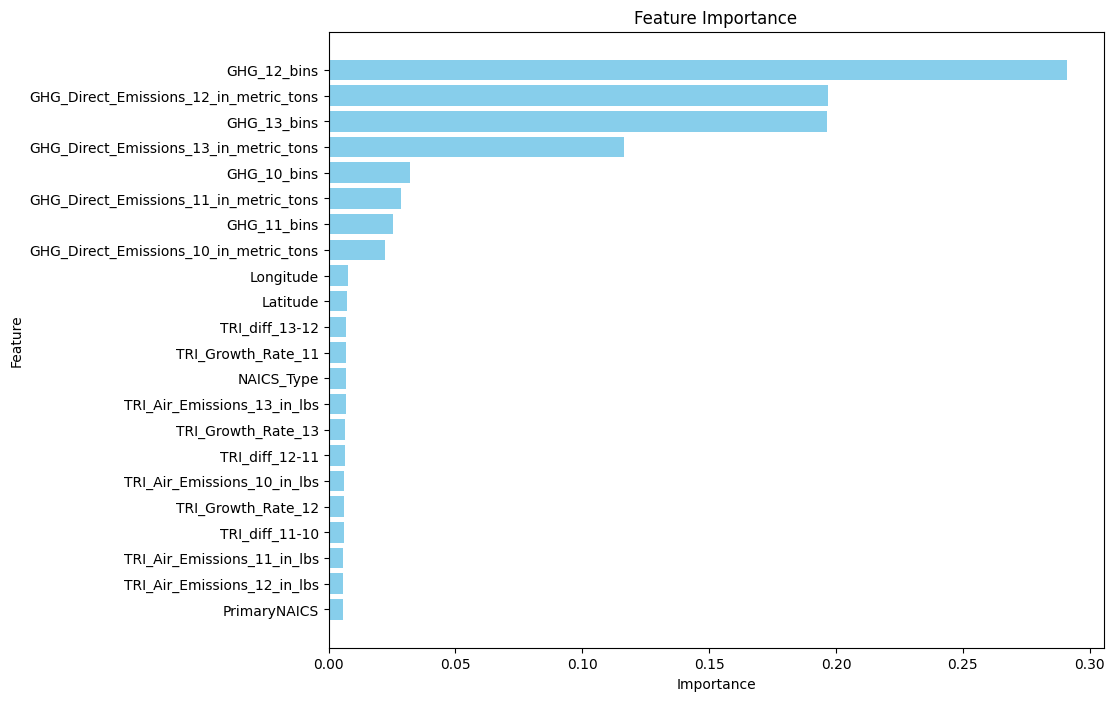

In [ ]:
from sklearn.metrics import root_mean_squared_log_error
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor
# from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import gc
import numpy as np
import lightgbm as lgb

gc.collect()

def get_models_trained(train, test, target, num_folds):
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

    oof_predictions = np.zeros(len(train))
    test_predictions = np.zeros(len(test))
    train_predictions = np.zeros(len(train))
    fold_train_rmsle = []
    feature_importance_df = pd.DataFrame()

    for fold, (train_index, valid_index) in enumerate(kf.split(train, target)):
        print(f"------------------------------ fold {fold} ------------------------------")

        X_train, X_valid = train.iloc[train_index], train.iloc[valid_index]
        y_train, y_valid = target.iloc[train_index], target.iloc[valid_index]

        model_dict = {}
        loss_dict = {}
        valid_preds_dict = {}
        train_preds_dict = {}
        rmsle_dict = {}

        # モデル1
        params1 = {
            'n_estimators': 595, 'learning_rate': 0.007624351393824647, 'subsample': 0.700276785552184, 'colsample_bytree': 0.7339579594424095, 'reg_alpha': 0.29107185146455633, 'reg_lambda': 2.641123852967307,
            "max_depth": 4,
            "random_state": 42,
            'enable_categorical': True,
        }
        model1 = XGBRegressor(**params1)

        # モデル1の学習と予測
        _ = model1.fit(X_train, np.log1p(y_train))
        valid_preds1 = np.expm1(model1.predict(X_valid))
        train_preds1 = np.expm1(model1.predict(X_train))
        rmsle1 = root_mean_squared_log_error(y_valid, valid_preds1)
        tr_rmsle1 = root_mean_squared_log_error(y_train, train_preds1)
        print(f"Fold {fold} model1 tr:{tr_rmsle1:.5f} va:{rmsle1:.5f}")

        loss_dict["model1"] = rmsle1
        model_dict['model1'] = model1
        valid_preds_dict['model1'] = valid_preds1
        train_preds_dict['model1'] = train_preds1
        rmsle_dict['model1'] = rmsle1

        # 取得した特徵重要度をデータフレームに追加
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = train.columns
        fold_importance_df["importance"] = model1.feature_importances_
        fold_importance_df["fold"] = fold
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)


        # 各モデルの予測の平均値を算出して評価
        valid_preds_mean = np.mean(list(valid_preds_dict.values()), axis=0)
        train_preds_mean = np.mean(list(train_preds_dict.values()), axis=0)

        rmsle_valid_mean = root_mean_squared_log_error(y_valid, valid_preds_mean)
        rmsle_train_mean = root_mean_squared_log_error(y_train, train_preds_mean)

        rmsle_mean = root_mean_squared_log_error(y_valid, valid_preds_mean)
        min_loss_model = min(loss_dict, key=loss_dict.get)
        model = model_dict[min_loss_model]
        valid_preds_best_model = np.expm1(model.predict(X_valid))
        rmsle_best = root_mean_squared_log_error(y_valid, valid_preds_best_model)
        train_preds_best_model = np.expm1(model.predict(X_train))
        tr_rmsle_best = root_mean_squared_log_error(y_train, train_preds_best_model)

        # print(f"Fold {fold} Ave    tr:{rmsle_train_mean:.5f} va:{rmsle_valid_mean:.5f}")

        oof_predictions[valid_index] = valid_preds_mean
        train_predictions[train_index] = train_preds_mean

        # テストデータの予測
        test_preds = model.predict(test)
        test_predictions += test_preds / kf.n_splits

        gc.collect()

    RMSLE = root_mean_squared_log_error(target, oof_predictions)
    tr_RMSLE = root_mean_squared_log_error(target, train_predictions)
    print()
    print(f"[CV] tr:{tr_RMSLE:.5f} va:{RMSLE:.5f}")

    # 特徵重要度の表示
    feature_importance_df = feature_importance_df.groupby("feature")["importance"].mean().sort_values(ascending=False).reset_index()
    plt.figure(figsize=(10, 8))
    plt.barh(feature_importance_df["feature"], feature_importance_df["importance"], color='skyblue')
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.title("Feature Importance")
    plt.gca().invert_yaxis()
    plt.show()

    return oof_predictions, train_predictions, np.expm1(test_predictions)

oof_predictions, train_predictions, test_predictions = get_models_trained(train, test, target, 15)

------------------------------ fold 0 ------------------------------
Fold 0 model2 tr:0.70085 va:0.67803
------------------------------ fold 1 ------------------------------
Fold 1 model2 tr:0.69489 va:0.77634
------------------------------ fold 2 ------------------------------
Fold 2 model2 tr:0.69622 va:0.76028
------------------------------ fold 3 ------------------------------
Fold 3 model2 tr:0.70035 va:0.68900
------------------------------ fold 4 ------------------------------
Fold 4 model2 tr:0.69641 va:0.75612
------------------------------ fold 5 ------------------------------
Fold 5 model2 tr:0.69611 va:0.77876
------------------------------ fold 6 ------------------------------
Fold 6 model2 tr:0.69749 va:0.73850
------------------------------ fold 7 ------------------------------
Fold 7 model2 tr:0.69514 va:0.76473
------------------------------ fold 8 ------------------------------
Fold 8 model2 tr:0.69062 va:0.82782
------------------------------ fold 9 -----------------

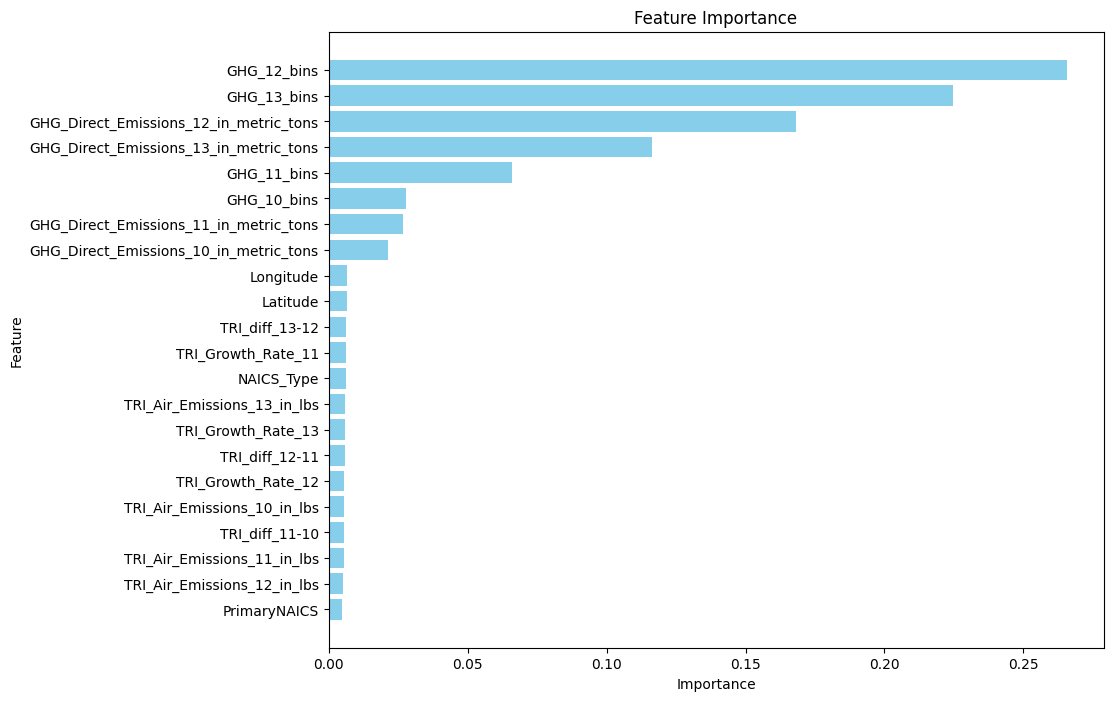

In [ ]:
from sklearn.metrics import root_mean_squared_log_error
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor
# from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import gc
import numpy as np
import lightgbm as lgb

gc.collect()

def get_models_trained(train, test, target, num_folds):
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

    oof_predictions = np.zeros(len(train))
    test_predictions = np.zeros(len(test))
    train_predictions = np.zeros(len(train))
    fold_train_rmsle = []
    feature_importance_df = pd.DataFrame()
    for fold, (train_index, valid_index) in enumerate(kf.split(train, target)):
        print(f"------------------------------ fold {fold} ------------------------------")

        X_train, X_valid = train.iloc[train_index], train.iloc[valid_index]
        y_train, y_valid = target.iloc[train_index], target.iloc[valid_index]

        model_dict = {}
        loss_dict = {}
        valid_preds_dict = {}
        train_preds_dict = {}
        rmsle_dict = {}

        params2 = {
            'n_estimators': 496, 'learning_rate': 0.009252715170077622, 'subsample': 0.7167164015002879, 'colsample_bytree': 0.6412076957770685, 'reg_alpha': 0.3696375956764805, 'reg_lambda': 2.467273343804692,
            "max_depth": 4,
            "random_state": 42,
            'enable_categorical': True,
        }
        model2 = XGBRegressor(**params2)

        # モデル2の学習と予測
        _ = model2.fit(X_train, np.log1p(y_train))
        valid_preds2 = np.expm1(model2.predict(X_valid))
        train_preds2 = np.expm1(model2.predict(X_train))
        rmsle2 = root_mean_squared_log_error(y_valid, valid_preds2)
        tr_rmsle2 = root_mean_squared_log_error(y_train, train_preds2)
        print(f"Fold {fold} model2 tr:{tr_rmsle2:.5f} va:{rmsle2:.5f}")

        loss_dict["model2"] = rmsle2
        model_dict['model2'] = model2
        valid_preds_dict['model2'] = valid_preds2
        train_preds_dict['model2'] = train_preds2
        rmsle_dict['model2'] = rmsle2

        # 取得した特徵重要度をデータフレームに追加
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = train.columns
        fold_importance_df["importance"] = model2.feature_importances_
        fold_importance_df["fold"] = fold
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)


        # 各モデルの予測の平均値を算出して評価
        valid_preds_mean = np.mean(list(valid_preds_dict.values()), axis=0)
        train_preds_mean = np.mean(list(train_preds_dict.values()), axis=0)

        rmsle_valid_mean = root_mean_squared_log_error(y_valid, valid_preds_mean)
        rmsle_train_mean = root_mean_squared_log_error(y_train, train_preds_mean)

        rmsle_mean = root_mean_squared_log_error(y_valid, valid_preds_mean)
        min_loss_model = min(loss_dict, key=loss_dict.get)
        model = model_dict[min_loss_model]
        valid_preds_best_model = np.expm1(model.predict(X_valid))
        rmsle_best = root_mean_squared_log_error(y_valid, valid_preds_best_model)
        train_preds_best_model = np.expm1(model.predict(X_train))
        tr_rmsle_best = root_mean_squared_log_error(y_train, train_preds_best_model)

        # print(f"Fold {fold} Ave    tr:{rmsle_train_mean:.5f} va:{rmsle_valid_mean:.5f}")

        oof_predictions[valid_index] = valid_preds_mean
        train_predictions[train_index] = train_preds_mean

        # テストデータの予測
        test_preds = model.predict(test)
        test_predictions += test_preds / kf.n_splits

        gc.collect()

    RMSLE = root_mean_squared_log_error(target, oof_predictions)
    tr_RMSLE = root_mean_squared_log_error(target, train_predictions)
    print()
    print(f"[CV] tr:{tr_RMSLE:.5f} va:{RMSLE:.5f}")

    # 特徵重要度の表示
    feature_importance_df = feature_importance_df.groupby("feature")["importance"].mean().sort_values(ascending=False).reset_index()
    plt.figure(figsize=(10, 8))
    plt.barh(feature_importance_df["feature"], feature_importance_df["importance"], color='skyblue')
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.title("Feature Importance")
    plt.gca().invert_yaxis()
    plt.show()

    return oof_predictions, train_predictions, np.expm1(test_predictions)

oof_predictions, train_predictions, test_predictions = get_models_trained(train, test, target, 15)

------------------------------ fold 0 ------------------------------
Fold 0 model3 tr:0.72725 va:0.67979
------------------------------ fold 1 ------------------------------
Fold 1 model3 tr:0.72005 va:0.77756
------------------------------ fold 2 ------------------------------
Fold 2 model3 tr:0.72296 va:0.76148
------------------------------ fold 3 ------------------------------
Fold 3 model3 tr:0.72738 va:0.68359
------------------------------ fold 4 ------------------------------
Fold 4 model3 tr:0.72276 va:0.76529
------------------------------ fold 5 ------------------------------
Fold 5 model3 tr:0.72117 va:0.78060
------------------------------ fold 6 ------------------------------
Fold 6 model3 tr:0.72352 va:0.73912
------------------------------ fold 7 ------------------------------
Fold 7 model3 tr:0.72216 va:0.76668
------------------------------ fold 8 ------------------------------
Fold 8 model3 tr:0.71708 va:0.82888
------------------------------ fold 9 -----------------

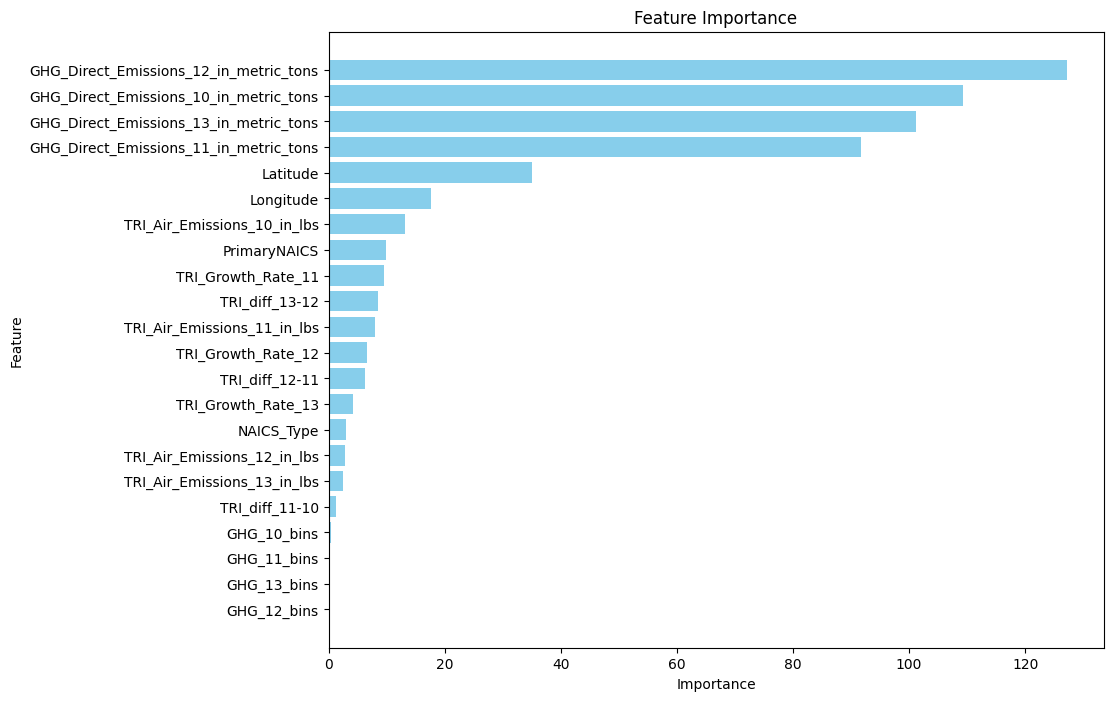

In [ ]:
from sklearn.metrics import root_mean_squared_log_error
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor
# from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import gc
import numpy as np
import lightgbm as lgb

gc.collect()

def get_models_trained(train, test, target, num_folds):
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

    oof_predictions = np.zeros(len(train))
    test_predictions = np.zeros(len(test))
    train_predictions = np.zeros(len(train))
    fold_train_rmsle = []
    feature_importance_df = pd.DataFrame()
    for fold, (train_index, valid_index) in enumerate(kf.split(train, target)):
        print(f"------------------------------ fold {fold} ------------------------------")

        X_train, X_valid = train.iloc[train_index], train.iloc[valid_index]
        y_train, y_valid = target.iloc[train_index], target.iloc[valid_index]

        model_dict = {}
        loss_dict = {}
        valid_preds_dict = {}
        train_preds_dict = {}
        rmsle_dict = {}

        # モデル3
        params3 = {
            'n_estimators': 86, 'learning_rate': 0.05997247493517289, 'lambda_l1': 0.039698269771453513, 'lambda_l2': 1.3209099884337212, 'min_data_in_leaf': 35, 'max_bin': 169,
            "max_depth": 3,
            "random_state": 42,
            'objective': 'regression',
            'metric': 'rmse',
            'boosting_type': 'gbdt',
            'verbose': -1,

        }
        model3 = LGBMRegressor(**params3)

        # モデル3の学習と予測
        model3.fit(
            X_train,
            np.log1p(y_train),
            eval_set=[(X_valid, y_valid)],
            callbacks=[
                lgb.early_stopping(stopping_rounds=50, verbose=False),
                lgb.log_evaluation(0)],
        )
        valid_preds3 = np.expm1(model3.predict(X_valid))
        train_preds3 = np.expm1(model3.predict(X_train))
        rmsle3 = root_mean_squared_log_error(y_valid, valid_preds3)
        tr_rmsle3 = root_mean_squared_log_error(y_train, train_preds3)
        print(f"Fold {fold} model3 tr:{tr_rmsle3:.5f} va:{rmsle3:.5f}")

        loss_dict["model3"] = rmsle3
        model_dict['model3'] = model3
        valid_preds_dict['model3'] = valid_preds3
        train_preds_dict['model3'] = train_preds3
        rmsle_dict['model3'] = rmsle3

        # 取得した特徵重要度をデータフレームに追加
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = train.columns
        fold_importance_df["importance"] = model3.feature_importances_
        fold_importance_df["fold"] = fold
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)


        # 各モデルの予測の平均値を算出して評価
        valid_preds_mean = np.mean(list(valid_preds_dict.values()), axis=0)
        train_preds_mean = np.mean(list(train_preds_dict.values()), axis=0)

        rmsle_valid_mean = root_mean_squared_log_error(y_valid, valid_preds_mean)
        rmsle_train_mean = root_mean_squared_log_error(y_train, train_preds_mean)

        rmsle_mean = root_mean_squared_log_error(y_valid, valid_preds_mean)
        min_loss_model = min(loss_dict, key=loss_dict.get)
        model = model_dict[min_loss_model]
        valid_preds_best_model = np.expm1(model.predict(X_valid))
        rmsle_best = root_mean_squared_log_error(y_valid, valid_preds_best_model)
        train_preds_best_model = np.expm1(model.predict(X_train))
        tr_rmsle_best = root_mean_squared_log_error(y_train, train_preds_best_model)

        # print(f"Fold {fold} Ave    tr:{rmsle_train_mean:.5f} va:{rmsle_valid_mean:.5f}")

        oof_predictions[valid_index] = valid_preds_mean
        train_predictions[train_index] = train_preds_mean

        # テストデータの予測
        test_preds = model.predict(test)
        test_predictions += test_preds / kf.n_splits

        gc.collect()

    RMSLE = root_mean_squared_log_error(target, oof_predictions)
    tr_RMSLE = root_mean_squared_log_error(target, train_predictions)
    print()
    print(f"[CV] tr:{tr_RMSLE:.5f} va:{RMSLE:.5f}")

    # 特徵重要度の表示
    feature_importance_df = feature_importance_df.groupby("feature")["importance"].mean().sort_values(ascending=False).reset_index()
    plt.figure(figsize=(10, 8))
    plt.barh(feature_importance_df["feature"], feature_importance_df["importance"], color='skyblue')
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.title("Feature Importance")
    plt.gca().invert_yaxis()
    plt.show()

    return oof_predictions, train_predictions, np.expm1(test_predictions)

oof_predictions, train_predictions, test_predictions = get_models_trained(train, test, target, 15)

------------------------------ fold 0 ------------------------------
Fold 0 model4 tr:0.72829 va:0.68245
------------------------------ fold 1 ------------------------------
Fold 1 model4 tr:0.72103 va:0.77987
------------------------------ fold 2 ------------------------------
Fold 2 model4 tr:0.72449 va:0.75971
------------------------------ fold 3 ------------------------------
Fold 3 model4 tr:0.72730 va:0.68320
------------------------------ fold 4 ------------------------------
Fold 4 model4 tr:0.72265 va:0.76192
------------------------------ fold 5 ------------------------------
Fold 5 model4 tr:0.72175 va:0.78217
------------------------------ fold 6 ------------------------------
Fold 6 model4 tr:0.72444 va:0.73857
------------------------------ fold 7 ------------------------------
Fold 7 model4 tr:0.72242 va:0.77155
------------------------------ fold 8 ------------------------------
Fold 8 model4 tr:0.71816 va:0.82683
------------------------------ fold 9 -----------------

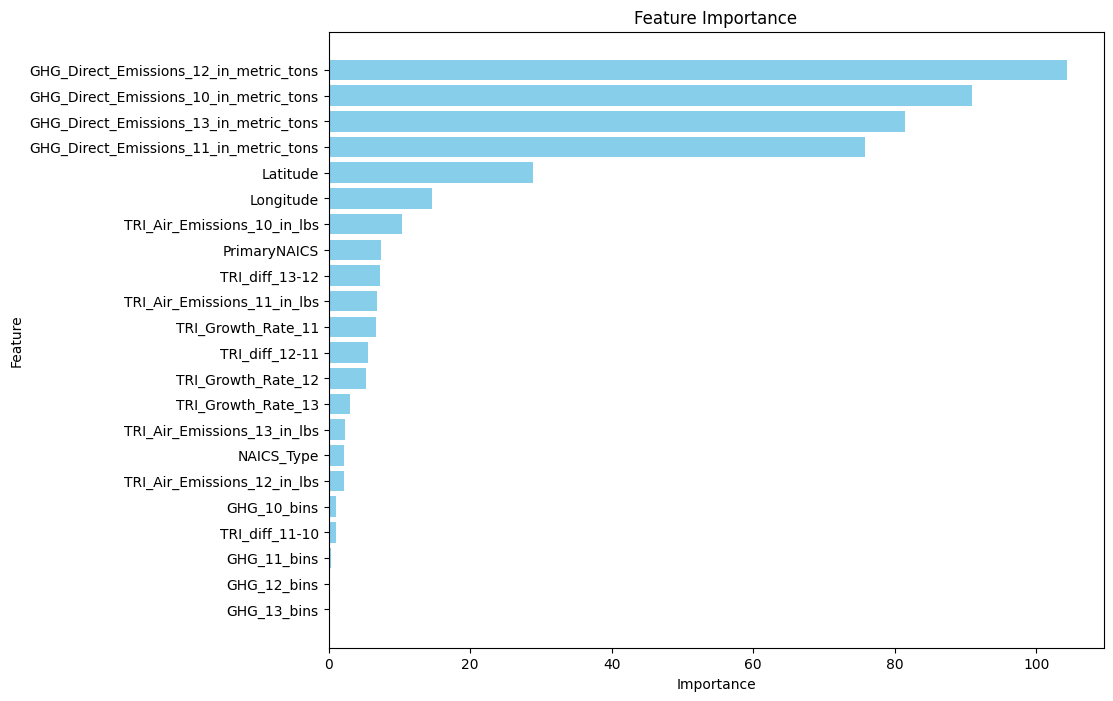

In [ ]:
from sklearn.metrics import root_mean_squared_log_error
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor
# from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import gc
import numpy as np
import lightgbm as lgb

gc.collect()

def get_models_trained(train, test, target, num_folds):
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

    oof_predictions = np.zeros(len(train))
    test_predictions = np.zeros(len(test))
    train_predictions = np.zeros(len(train))
    fold_train_rmsle = []
    feature_importance_df = pd.DataFrame()
    for fold, (train_index, valid_index) in enumerate(kf.split(train, target)):
        print(f"------------------------------ fold {fold} ------------------------------")

        X_train, X_valid = train.iloc[train_index], train.iloc[valid_index]
        y_train, y_valid = target.iloc[train_index], target.iloc[valid_index]

        model_dict = {}
        loss_dict = {}
        valid_preds_dict = {}
        train_preds_dict = {}
        rmsle_dict = {}

        # モデル4
        params4 = {
            'n_estimators': 70, 'learning_rate': 0.07163113404511691, 'lambda_l1': 0.018462551672613223, 'lambda_l2': 1.6493096737478277, 'min_data_in_leaf': 34, 'max_bin': 170,
            "max_depth": 3,
            "random_state": 42,
            'objective': 'regression',
            'metric': 'rmse',
            'boosting_type': 'gbdt',
            'verbose': -1,
        }
        model4 = LGBMRegressor(**params4)

        # モデル4の学習と予測
        model4.fit(
            X_train,
            np.log1p(y_train),
            eval_set=[(X_valid, y_valid)],
            callbacks=[
                lgb.early_stopping(stopping_rounds=50, verbose=False),
                lgb.log_evaluation(0)],
        )
        valid_preds4 = np.expm1(model4.predict(X_valid))
        train_preds4 = np.expm1(model4.predict(X_train))
        rmsle4 = root_mean_squared_log_error(y_valid, valid_preds4)
        tr_rmsle4 = root_mean_squared_log_error(y_train, train_preds4)
        print(f"Fold {fold} model4 tr:{tr_rmsle4:.5f} va:{rmsle4:.5f}")

        loss_dict["model4"] = rmsle4
        model_dict['model4'] = model4
        valid_preds_dict['model4'] = valid_preds4
        train_preds_dict['model4'] = train_preds4
        rmsle_dict['model4'] = rmsle4

        # 取得した特徵重要度をデータフレームに追加
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = train.columns
        fold_importance_df["importance"] = model4.feature_importances_
        fold_importance_df["fold"] = fold
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)


        # 各モデルの予測の平均値を算出して評価
        valid_preds_mean = np.mean(list(valid_preds_dict.values()), axis=0)
        train_preds_mean = np.mean(list(train_preds_dict.values()), axis=0)

        rmsle_valid_mean = root_mean_squared_log_error(y_valid, valid_preds_mean)
        rmsle_train_mean = root_mean_squared_log_error(y_train, train_preds_mean)

        rmsle_mean = root_mean_squared_log_error(y_valid, valid_preds_mean)
        min_loss_model = min(loss_dict, key=loss_dict.get)
        model = model_dict[min_loss_model]
        valid_preds_best_model = np.expm1(model.predict(X_valid))
        rmsle_best = root_mean_squared_log_error(y_valid, valid_preds_best_model)
        train_preds_best_model = np.expm1(model.predict(X_train))
        tr_rmsle_best = root_mean_squared_log_error(y_train, train_preds_best_model)

        # print(f"Fold {fold} Ave    tr:{rmsle_train_mean:.5f} va:{rmsle_valid_mean:.5f}")

        oof_predictions[valid_index] = valid_preds_mean
        train_predictions[train_index] = train_preds_mean

        # テストデータの予測
        test_preds = model.predict(test)
        test_predictions += test_preds / kf.n_splits

        gc.collect()

    RMSLE = root_mean_squared_log_error(target, oof_predictions)
    tr_RMSLE = root_mean_squared_log_error(target, train_predictions)
    print()
    print(f"[CV] tr:{tr_RMSLE:.5f} va:{RMSLE:.5f}")

    # 特徵重要度の表示
    feature_importance_df = feature_importance_df.groupby("feature")["importance"].mean().sort_values(ascending=False).reset_index()
    plt.figure(figsize=(10, 8))
    plt.barh(feature_importance_df["feature"], feature_importance_df["importance"], color='skyblue')
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.title("Feature Importance")
    plt.gca().invert_yaxis()
    plt.show()

    return oof_predictions, train_predictions, np.expm1(test_predictions)

oof_predictions, train_predictions, test_predictions = get_models_trained(train, test, target, 15)

# 提出データ

In [ ]:
submit = pd.read_csv('/content/drive/MyDrive/GHGの排出量の予測にチャレンジしよう！（SMBC Group GREEN×DATA Challenge 2024）/提供データ/sample_submission.csv', header=None)
submit[1] = test_predictions
submit.to_csv('submit_ghg48_1.csv', header=None, index=False)

# 投稿ファイルの中身を確認
submit.head()

,0,1
0,4655,47097.258831
1,4656,297479.263689
2,4657,40270.186384
3,4658,27331.510277
4,4659,46401.837886
